In [6]:
import pandas as pd
import numpy as np
import os
import pydicom
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

In [7]:
# Load the CSV file
data_path = '/mnt/win_share/GitHub/AI-ethnicity-med-image/data/axial_lung_ct_images.csv'
df = pd.read_csv(data_path)

In [8]:
# Convert any Windows-style paths to Unix-style paths
df['File Location'] = df['File Location'].apply(lambda x: x.replace("\\", "/"))

In [9]:
# Group by 'Subject ID' to handle multiple images per patient
grouped = df.groupby('Subject ID')

# Randomly select one image per patient
df_single_image_per_patient = grouped.apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)

# Label mapping for converting race categories to integers
label_mapping = {
    "White": 0,
    "Black or African-American": 1,
    "Asian": 2,
    "American Indian or Alaskan Native": 3,
    "Native Hawaiian or Other Pacific Islander": 4
}

# Convert the 'Patient Race' to integer labels
df_single_image_per_patient['Race_Label'] = df_single_image_per_patient['Patient Race'].map(label_mapping)

In [10]:
num_patients = df_single_image_per_patient['Subject ID'].nunique()
num_images = len(df_single_image_per_patient)

# Print the results
print(f"Number of unique patients: {num_patients}")
print(f"Number of images after selecting one per patient: {num_images}")

Number of unique patients: 15639
Number of images after selecting one per patient: 15639


In [11]:
# Downsampling and Upsampling Strategy
desired_samples = {
    "White": 2000,  # Downsample to 2000
    "Black or African-American": 1135,  # Upsample
    "Asian": 1135,  # Upsample
    "American Indian or Alaskan Native": 1135,  # Upsample
    "Native Hawaiian or Other Pacific Islander": 1135  # Upsample
}

resampled_df = pd.DataFrame()

for race, target_count in desired_samples.items():
    race_df = df_single_image_per_patient[df_single_image_per_patient['Patient Race'] == race]
    
    if len(race_df) > target_count:
        resampled_df = pd.concat([resampled_df, race_df.sample(target_count, random_state=42)])
    else:
        resampled_df = pd.concat([resampled_df, race_df.sample(target_count, replace=True, random_state=42)])

resampled_df = resampled_df.reset_index(drop=True)

In [12]:
# Check class distribution
print("Class distribution after resampling:")
print(resampled_df['Patient Race'].value_counts())

Class distribution after resampling:
Patient Race
White                                        2000
Black or African-American                    1135
Asian                                        1135
American Indian or Alaskan Native            1135
Native Hawaiian or Other Pacific Islander    1135
Name: count, dtype: int64


In [13]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    resampled_df['File Location'],
    resampled_df['Race_Label'],
    test_size=0.2,
    stratify=resampled_df['Race_Label'],
    random_state=42
)

In [14]:
# Change to current directory
os.chdir('/media/yu-tingtseng_sa/16TB IronWolf Pro/Data/NLST/Radiology CT Images/manifest-NLST_allCT')
print(os.getcwd())

/media/yu-tingtseng_sa/16TB IronWolf Pro/Data/NLST/Radiology CT Images/manifest-NLST_allCT


In [15]:
# Preprocess images for model input
def preprocess_images(file_paths, labels):
    image_data = []
    processed_labels = []
    
    # Ensure only one image per patient (process the first DICOM file found)
    for file_path, label in zip(file_paths, labels):
        dicom_folder = file_path  # Path to the folder containing DICOM images
        dicom_files = [f for f in os.listdir(dicom_folder) if f.endswith('.dcm')]  # List DICOM files
        
        if dicom_files:
            dicom_file = dicom_files[0]  # Select the first DICOM file only
            dicom_path = os.path.join(dicom_folder, dicom_file)
            ds = pydicom.dcmread(dicom_path)  # Read the DICOM file
            img_array = ds.pixel_array  # Extract pixel array

            # Normalize the image
            img_array = img_array / np.max(img_array)  # Normalize to [0, 1]

            # Resize the image
            img = Image.fromarray(img_array)  # Convert to PIL image
            img = img.resize((512, 512))  # Resize to 512x512 pixels
            img_array_resized = np.array(img)  # Convert back to numpy array

            # Convert grayscale image to 3-channel RGB by repeating the single channel 3 times
            img_array_rgb = np.stack([img_array_resized] * 3, axis=-1)

            image_data.append(img_array_rgb)
            processed_labels.append(label)  # Append the corresponding label
    
    return np.array(image_data), np.array(processed_labels)

In [16]:
# Preprocess images for training and validation sets (ensure 1 image per patient)
X_train_images, y_train_labels = preprocess_images(X_train, y_train)
X_val_images, y_val_labels = preprocess_images(X_val, y_val)

In [17]:
# Check the number of images
num_train_images = X_train_images.shape[0]
num_val_images = X_val_images.shape[0]

print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_val_images}")
print(f"Number of training labels: {len(y_train_labels)}")
print(f"Number of validation labels: {len(y_val_labels)}")


Number of training images: 5232
Number of validation images: 1308
Number of training labels: 5232
Number of validation labels: 1308


In [13]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: []


2024-11-20 10:31:42.742153: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-20 10:31:42.742372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-20 10:31:42.742893: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:LD_LIBRARY_PATH
2024-11-20 10:31:42.743215: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or direct

In [ ]:
# Load the pre-trained EfficientNetB0 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the pre-trained model
x = base_model.output
x = Flatten()(x)  # Flatten the output
x = Dense(128, activation='relu')(x)  # Fully connected layer
output = Dense(len(label_mapping), activation='softmax')(x)  # Output layer with softmax activation for multiclass classification

2024-11-20 10:31:42.790008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
# Create the complete model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using the generator
history = model.fit(X_train_images, 
                    y_train_labels, 
                    validation_data=(X_val_images, y_val_labels), 
                    epochs=50, 
                    batch_size=32)

# Save the model
# model.save('ethnicity_classification_model.h5')

Epoch 1/50


2024-11-20 10:31:43.665885: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 16458448896 exceeds 10% of free system memory.


ValueError: in user code:

    File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 512, 512, 3)


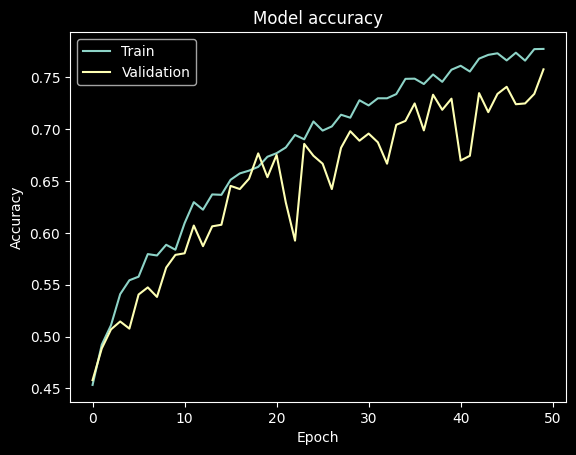

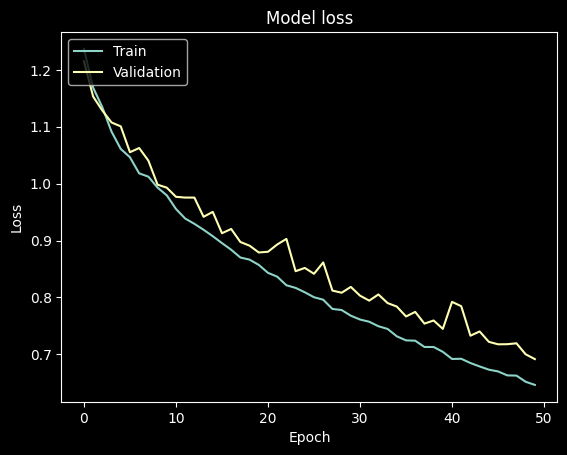

In [ ]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Make predictions on the validation set
y_pred = model.predict(X_val_images)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

41/41 [==============================] - 16s 380ms/step


Accuracy: 0.7576


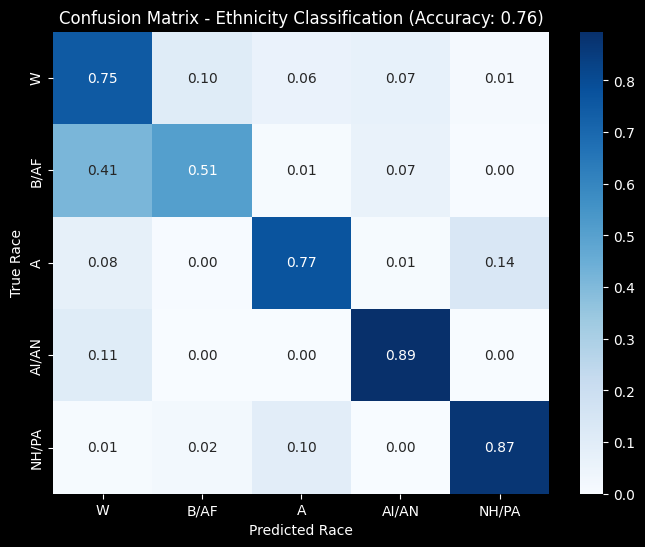

In [ ]:
# Create a confusion matrix
cm = confusion_matrix(y_val_labels, y_pred_labels)

cma = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Define race labels
race_labels = ['W', 'B/AF', 'A', 'AI/AN', 'NH/PA']

# Calculate accuracy
accuracy = accuracy_score(y_val_labels, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cma, annot=True, fmt='.2f', cmap='Blues', xticklabels=race_labels, yticklabels=race_labels)
plt.xlabel('Predicted Race')
plt.ylabel('True Race')
plt.title(f'Confusion Matrix - Ethnicity Classification (Accuracy: {accuracy:.2f})')
plt.show()

In [ ]:
# Print a detailed classification report
print("Classification Report:")
print(classification_report(y_val_labels, y_pred_labels, target_names=label_mapping.keys(), zero_division=1))

Classification Report:
                                           precision    recall  f1-score   support

                                    White       0.62      0.72      0.67       400
                Black or African-American       0.58      0.50      0.54       227
                                    Asian       0.57      0.81      0.67       227
        American Indian or Alaskan Native       0.87      0.69      0.77       227
Native Hawaiian or Other Pacific Islander       0.87      0.55      0.67       227

                                 accuracy                           0.67      1308
                                macro avg       0.70      0.66      0.66      1308
                             weighted avg       0.69      0.67      0.67      1308

